# Time Series Forecasting with Linear Learner
#### Using Linear Regression to Forecast Monthly Demand
This notebook will build a linear model to forecast weekly output for US gasoline products starting in 1991 to 2005. It will focus almost exclusively on the application. Our dataset is a single time-series, so we'll use SageMaker's Linear Learner algorithm. If we had multiple, related time-series, we would use SageMaker's DeepAR algorithm, which is specifically designed for forecasting.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import time
import json
import sagemaker.amazon.common as smac
import sagemaker
from sagemaker.predictor import csv_serializer, json_deserializer

In [41]:
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'gasoline-barrrels'

## Data
Download the data. 

In [42]:
!wget http://robjhyndman.com/data/gasoline.csv

--2020-02-14 16:58:13--  http://robjhyndman.com/data/gasoline.csv
Resolving robjhyndman.com (robjhyndman.com)... 35.208.79.31
Connecting to robjhyndman.com (robjhyndman.com)|35.208.79.31|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://robjhyndman.com/data/gasoline.csv [following]
--2020-02-14 16:58:13--  https://robjhyndman.com/data/gasoline.csv
Connecting to robjhyndman.com (robjhyndman.com)|35.208.79.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4530 (4.4K) [text/csv]
Saving to: ‘gasoline.csv.1’

gasoline.csv.1      100%[===================>]   4.42K  --.-KB/s    in 0s      

2020-02-14 16:58:14 (515 MB/s) - ‘gasoline.csv.1’ saved [4530/4530]



And take a look at it.

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


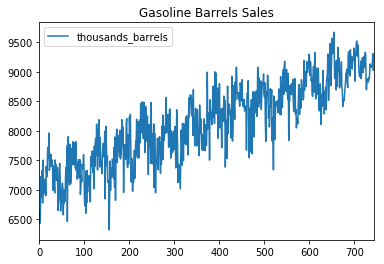

In [66]:
gas_df = pd.read_csv('gasoline.csv', header = None, names=['thousands_barrels'])
display(gas_df.head())
gas_df.plot(title='Gasoline Barrels Sales')
plt.show()

As we can see, there's a definitive upward trend, some yearly seasonality, but sufficient volatility to make the problem non-trivial. There are several unexpected dips and years with more or less pronounced seasonality. These same characteristics are common in many topline time-series.

## Transform the Data
Next we'll transform the dataset to make it look a bit more like a standard prediction model. Our target variable is thousands_barrels. Let's create explanatory features, like:

* thousands_barrels for each of the 4 preceeding weeks.
* Trend. The chart above suggests the trend is simply linear, but we'll create log and quadratic trends in case.
* Indicator variables {0 or 1} that will help capture seasonality and key holiday weeks.

In [44]:
gas_df['thousands_barrels_lag1'] = gas_df['thousands_barrels'].shift(1)
gas_df['thousands_barrels_lag2'] = gas_df['thousands_barrels'].shift(2)
gas_df['thousands_barrels_lag3'] = gas_df['thousands_barrels'].shift(3)
gas_df['thousands_barrels_lag4'] = gas_df['thousands_barrels'].shift(4)
gas_df['trend'] = np.arange(len(gas_df))
gas_df['log_trend'] = np.log1p(np.arange(len(gas_df)))
gas_df['sq_trend'] = np.arange(len(gas)) ** 2
weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(gas_df)], prefix='week')
gas_df = pd.concat([gas_df, weeks], axis=1)

Now, we'll:

* Clear out the first four rows where we don't have lagged information.
* Split the target off from the explanatory features.
* Split the data into training, validation, and test groups so that we can tune our model and then evaluate its accuracy on data it hasn't seen yet. Since this is time-series data, we'll use the first 60% for training, the second 20% for validation, and the final 20% for final test evaluation.

In [45]:
gas_df = gas_df.iloc[4:, ]
split_train = int(len(gas) * 0.6)
split_test = int(len(gas) * 0.8)

train_y = gas_df['thousands_barrels'][:split_train]
train_X = gas_df.drop('thousands_barrels', axis=1).iloc[:split_train, ].as_matrix()
validation_y = gas_df['thousands_barrels'][split_train:split_test]
validation_X = gas_df.drop('thousands_barrels', axis=1).iloc[split_train:split_test, ].as_matrix()
test_y = gas_df['thousands_barrels'][split_test:]
test_X = gas_df.drop('thousands_barrels', axis=1).iloc[split_test:, ].as_matrix()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## Convert the datasets and upload
Convert the datasets to the recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms and upload this data to S3. We'll start with training data.

In [46]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(train_X).astype('float32'), np.array(train_y).astype('float32'))
buf.seek(0)

0

In [47]:
key = 'linear_train.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-eu-west-1-392009495238/gasoline-barrrels/train/linear_train.data


Next convert the validation data

In [48]:
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, np.array(validation_X).astype('float32'), np.array(validation_y).astype('float32'))
buf.seek(0)

0

In [49]:
key = 'linear_validation.data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(buf)

s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://sagemaker-eu-west-1-392009495238/gasoline-barrrels/validation/linear_validation.data


## Train
Configure the container image to be used for the region that we are running in

In [50]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'linear-learner')
s3_output_path = 's3://{}/{}/output'.format(bucket, prefix)

In [51]:
linear = sagemaker.estimator.Estimator(container, 
                                     role,
                                     output_path=s3_output_path,
                                     train_instance_count=1,
                                     train_instance_type = 'ml.c4.xlarge',
                                     sagemaker_session=sagemaker_session)

linear.set_hyperparameters(feature_dim=59,
                           mini_batch_size=100,
                           predictor_type='regressor',
                           epochs=10,
                           num_models=32,
                           loss='absolute_loss')

In [52]:
data_channels = {
    'train': s3_train_data,
    'validation': s3_validation_data
}

linear.fit(inputs=data_channels)

2020-02-14 17:01:03 Starting - Starting the training job...
2020-02-14 17:01:04 Starting - Launching requested ML instances......
2020-02-14 17:02:30 Starting - Preparing the instances for training......
2020-02-14 17:03:27 Downloading - Downloading input data...
2020-02-14 17:03:54 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[02/14/2020 17:04:16 INFO 139904262858560] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'init_sigma': u'0.01', u'lr_scheduler_minimum_lr': u

## Create and Deploy a Predictor
Now that we have trained a model, we can use it to perform predictions by deploying it to a predictor endpoint.

In [53]:
linear_predictor = linear.deploy(initial_instance_count = 1,
                                instance_type = 'ml.m4.xlarge')

-----------!

## Forecast
Start by generating the naive forecast.

In [70]:
gas_df['thousands_barrels_lag52'] = gas_df['thousands_barrels'].shift(52)
gas_df['thousands_barrels_lag104'] = gas_df['thousands_barrels'].shift(104)
gas_df['thousands_barrels_naive_forecast'] = gas_df['thousands_barrels_lag52'] ** 2 / gas_df['thousands_barrels_lag104']
naive = gas_df[split_test:]['thousands_barrels_naive_forecast'].values

And investigating it's accuracy.

Naive MdAPE = 0.03687277085962615


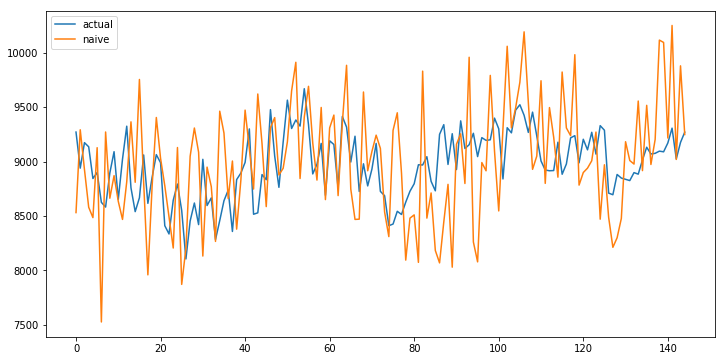

In [60]:
print('Naive MdAPE =', np.median(np.abs(test_y - naive) / test_y))
plt.figure(figsize=(12,6))
plt.plot(np.array(test_y), label='actual')
plt.plot(naive, label='naive')
plt.legend()
plt.show()

Generate the one-step-ahead forecast.

First convert numpy arrays into a CSV format that can be handled by the HTTP POST request we pass to the inference container.

For common formats we can use the Amazon SageMaker Python SDK's built in csv_serializer and json_deserializer functions.

In [71]:
linear_predictor.content_type = 'text/csv'
linear_predictor.serializer = csv_serializer
linear_predictor.deserializer = json_deserializer

Invoke the endpoint to get predictions.

In [72]:
result = linear_predictor.predict(test_X)
one_step = np.array([r['score'] for r in result['predictions']])

Compare forecast errors

One-step-ahead MdAPE =  0.02042460332342352


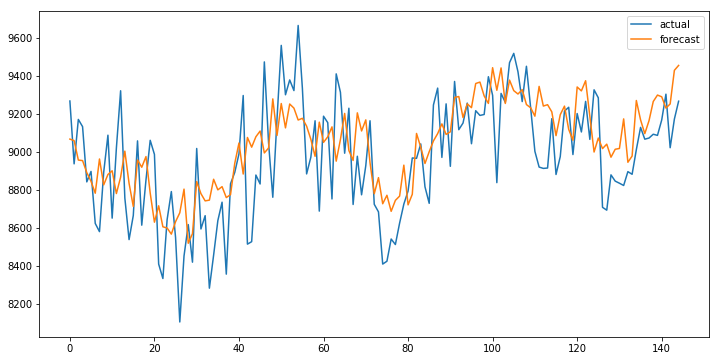

In [74]:
print('One-step-ahead MdAPE = ', np.median(np.abs(test_y - one_step) / test_y))
plt.figure(figsize=(12,6))
plt.plot(np.array(test_y), label='actual')
plt.plot(one_step, label='forecast')
plt.legend()
plt.show()

As we can see our MdAPE is substantially better than the naive, and we actually swing from a forecasts that's too volatile to one that under-represents the noise in our data. However, the overall shape of the statistical forecast does appear to better represent the actual data.

Next, let's generate multi-step-ahead forecast. To do this, we'll need to loop over invoking the endpoint one row at a time and make sure the lags in our model are updated appropriately.

In [75]:
multi_step = []
lags = test_X[0, 0:4]
for row in test_X:
    row[0:4] = lags
    result = linear_predictor.predict(row)
    prediction = result['predictions'][0]['score']
    multi_step.append(prediction)
    lags[1:4] = lags[0:3]
    lags[0] = prediction

multi_step = np.array(multi_step)

Calculate the accuracy of these predictions

Multi-step-ahead MdAPE = 0.02169955344803759


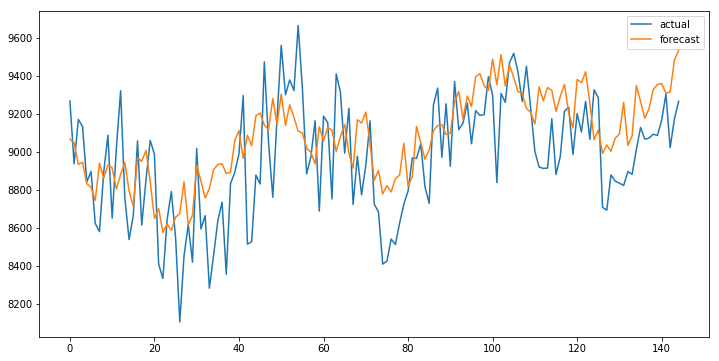

In [76]:
print('Multi-step-ahead MdAPE =', np.median(np.abs(test_y - multi_step) / test_y))
plt.figure(figsize=(12,6))
plt.plot(np.array(test_y), label='actual')
plt.plot(multi_step, label='forecast')
plt.legend()
plt.show()

The multi-step ahead error performs worse than our one-step ahead forecast, but nevertheless remains substantially stronger than the naive benchmark forecast. This 1.5 percentage point difference may not seem particularly meaningful, but at the large scale of many topline forecasts can mean millions of dollars in excess supply or lost sales.

Our linear model does a good job of predicting gasoline demand, but of course, improvements could be made. The fact that statistical forecast actually underrepresents some of the volatility in the data could suggest that we have actually over-regularized the data. Or, perhaps our choice of absolute loss was incorrect. Rerunning the model with further tweaks to these hyperparameters may provide more accurate out of sample forecasts. 

We also did not do a large amount of feature engineering. Occasionally, the lagging time-periods have complex interrelationships with one another that should be explored. 

Finally, alternative forecasting algorithms could be explored. Less interpretable methods like ARIMA, and black-box methods like LSTM Recurrent Neural Networks have been shown to predict time-series very well. 

## Clean UP

In [78]:
linear_predictor.delete_endpoint()